In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
"""
Extrai o dataset SPIE-AAPM Lung CT Challenge do drive. O conjunto de imagens pode ser acessado no link abaixo:
  - https://wiki.cancerimagingarchive.net/display/Public/SPIE-AAPM+Lung+CT+Challenge#19039197a19462154cc74bea92039089e61a0f44
"""

!unzip -q /content/drive/MyDrive/TCC/dataset.zip

In [4]:
!mkdir ndataset
!mkdir ndataset/malignant
!mkdir ndataset/benign

In [5]:
import os
from PIL import Image

dataset_dir = 'dataset'
ndataset_dir = 'ndataset'

for class_name in ['malignant', 'benign']:
    class_dir = os.path.join(ndataset_dir, class_name)
    if not os.path.exists(class_dir):
        os.makedirs(class_dir)

for class_name in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_dir):
        for image_file in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_file)
            if os.path.isfile(image_path):
                image = Image.open(image_path)
                new_image = image.resize((180, 180))
                save_dir = os.path.join(ndataset_dir, class_name)
                save_path = os.path.join(save_dir, image_file)
                new_image.save(save_path)

In [6]:
IMAGE_SIZE = (180, 180)
BATCH_SIZE = 32

train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'ndataset',
    validation_split=0.2,
    subset='both',
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 19084 files belonging to 2 classes.
Using 15268 files for training.
Using 3816 files for validation.


In [7]:
data_augmentation = keras.Sequential(
    [
      layers.RandomFlip('horizontal'),
      layers.RandomRotation(0.1),
      layers.RandomContrast(0.2),
      layers.RandomZoom(0.2),
      layers.RandomTranslation(0.1, 0.1)
    ]
)

94765736/94765736 [==============================] - 0s 0us/step


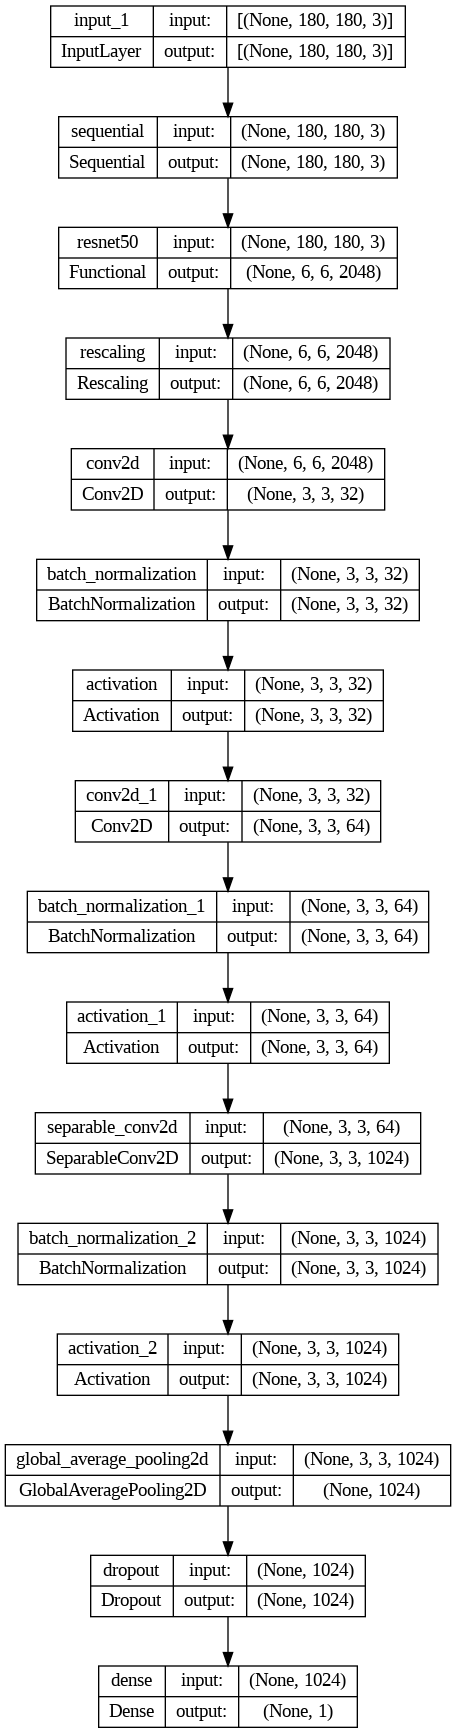

In [8]:
from keras.applications import ResNet50

def make_model(input_shape):
    inputs = keras.Input(shape=input_shape)

    x = data_augmentation(inputs)

    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    x = base_model(x)
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(1024, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    return keras.Model(inputs, outputs, name='vgg16')

model = make_model(input_shape=(180, 180, 3))
keras.utils.plot_model(model, show_shapes=True)

In [9]:
import keras.backend as K

def f1_score(y_true, y_pred):
    y_true = K.round(y_true)
    y_pred = K.round(y_pred)
    tp = K.sum(y_true * y_pred)
    fp = K.sum((1 - y_true) * y_pred)
    fn = K.sum(y_true * (1 - y_pred))
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    return 2 * precision * recall / (precision + recall + K.epsilon())

In [10]:
EPOCHS = 70

callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5")]

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), f1_score]
)

In [11]:
history = model.fit(train_ds, epochs=EPOCHS, callbacks=callbacks, validation_data=val_ds)

Epoch 1/70
478/478 [==============================] - 85s 70ms/step - loss: 0.6755 - accuracy: 0.5668 - precision: 0.5544 - recall: 0.5500 - f1_score: 0.5468 - val_loss: 0.6833 - val_accuracy: 0.5582 - val_precision: 0.5267 - val_recall: 0.9577 - val_f1_score: 0.6754
Epoch 2/70
478/478 [==============================] - 31s 65ms/step - loss: 0.4601 - accuracy: 0.7810 - precision: 0.7465 - recall: 0.8313 - f1_score: 0.7833 - val_loss: 0.4523 - val_accuracy: 0.7883 - val_precision: 0.7681 - val_recall: 0.8125 - val_f1_score: 0.7837
Epoch 3/70
478/478 [==============================] - 31s 65ms/step - loss: 0.2693 - accuracy: 0.8908 - precision: 0.8710 - recall: 0.9099 - f1_score: 0.8877 - val_loss: 0.3073 - val_accuracy: 0.8614 - val_precision: 0.8521 - val_recall: 0.8672 - val_f1_score: 0.8565
Epoch 4/70
478/478 [==============================] - 31s 65ms/step - loss: 0.1700 - accuracy: 0.9365 - precision: 0.9286 - recall: 0.9417 - f1_score: 0.9324 - val_loss: 0.2696 - val_accuracy: 0.8

120/120 [==============================] - 2s 16ms/step - loss: 0.0235 - accuracy: 0.9911 - precision: 0.9821 - recall: 1.0000 - f1_score: 0.9911
Test Loss: 0.02350873500108719
Test Accuracy: 0.9910901188850403
Test Precision: 0.9821146726608276
Test Recall: 1.0
Test F1Score: 0.9910604357719421


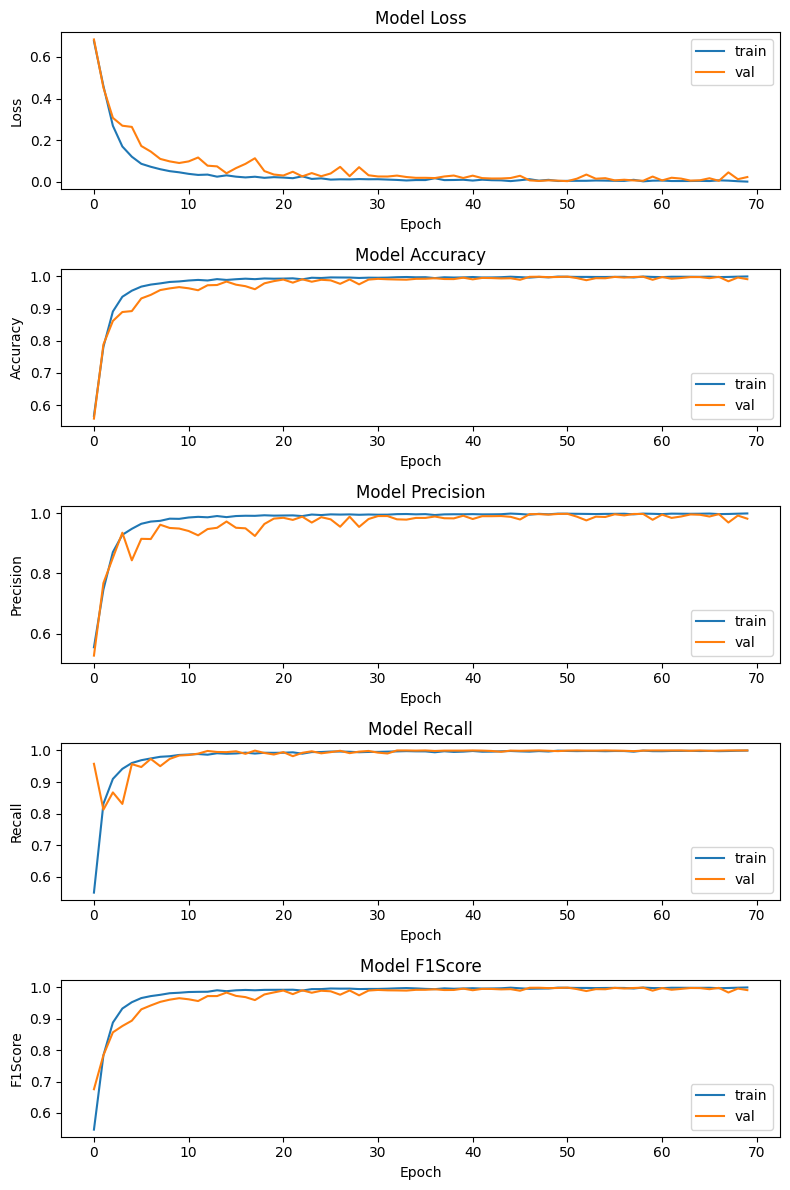

In [12]:
import matplotlib.pyplot as plt

test_loss, test_acc, test_precision, test_recall, test_f1_score = model.evaluate(val_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
print('Test Precision:', test_precision)
print('Test Recall:', test_recall)
print('Test F1Score:', test_f1_score)

fig, axs = plt.subplots(5, figsize=(8, 12))

# Loss plot
axs[0].plot(history.history['loss'], label='train')
axs[0].plot(history.history['val_loss'], label='val')
axs[0].set_title('Model Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Accuracy plot
axs[1].plot(history.history['accuracy'], label='train')
axs[1].plot(history.history['val_accuracy'], label='val')
axs[1].set_title('Model Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Precision plot
axs[2].plot(history.history['precision'], label='train')
axs[2].plot(history.history['val_precision'], label='val')
axs[2].set_title('Model Precision')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Precision')
axs[2].legend()

# Recall plot
axs[3].plot(history.history['recall'], label='train')
axs[3].plot(history.history['val_recall'], label='val')
axs[3].set_title('Model Recall')
axs[3].set_xlabel('Epoch')
axs[3].set_ylabel('Recall')
axs[3].legend()

# F1Score plot
axs[4].plot(history.history['f1_score'], label='train')
axs[4].plot(history.history['val_f1_score'], label='val')
axs[4].set_title('Model F1Score')
axs[4].set_xlabel('Epoch')
axs[4].set_ylabel('F1Score')
axs[4].legend()

plt.tight_layout()
plt.show()

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

threshold = 0.999 # Limiar de decisão

y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_pred = model.predict(val_ds)

y_true_binary = y_true.astype(int)
y_pred_binary = (y_pred > threshold).astype(int)

conf_matrix = confusion_matrix(y_true_binary, y_pred_binary)
class_report = classification_report(y_true_binary, y_pred_binary)

print('Confusion Matrix:', conf_matrix)
print('Classification Report:', class_report)

120/120 [==============================] - 3s 13ms/step
Confusion Matrix: [[1949    0]
 [  31 1836]]
Classification Report:               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1949
           1       1.00      0.98      0.99      1867

    accuracy                           0.99      3816
   macro avg       0.99      0.99      0.99      3816
weighted avg       0.99      0.99      0.99      3816

